## Next Steps 

* decide on normalization method 
* create CNN without transfer learning
* use ImageAug to transform images, retrain CNN without transfer learning
* create CNN with transfer learning 

In [1]:
# !pip install --upgrade imgaug

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import h5py
from skimage.transform import resize
from imgaug import augmenters as iaa


In [3]:
train_path = '../input/food41/food_c101_n1000_r384x384x3.h5'
test_path = '../input/food41/food_test_c101_n1000_r128x128x3.h5'


In [4]:
#opening training data 

f = h5py.File(train_path, "r")
f.keys()
train_images = f['images'][...]
train_category = f['category'][...]
train_category_names = f['category_names'][...]
f.close()

In [5]:
#opening testing data 

f = h5py.File(test_path, "r")
f.keys()
test_images = f['images'][...]
test_category = f['category'][...]
test_category_names = f['category_names'][...]
f.close()

In [6]:
print('Shape of train_category: ', train_category.shape)
print('Shape of train_images: ', train_images.shape)


print('Shape of test_category: ', test_category.shape)
print('Shape of test_images: ', test_images.shape)

Shape of train_category:  (1000, 101)
Shape of train_images:  (1000, 384, 384, 3)
Shape of test_category:  (1000, 101)
Shape of test_images:  (1000, 128, 128, 3)


In [7]:
# resized training images to match testing size 
# is this necessary? to have the training shape match the test shape? 

train_resized = np.zeros((1000,128,128,3))

for n,i in enumerate(train_images):
    train_resized[n,:,:,:] = resize(train_images[n,:,:,:], train_resized.shape[1:], anti_aliasing=True)

print(train_resized.shape)


(1000, 128, 128, 3)


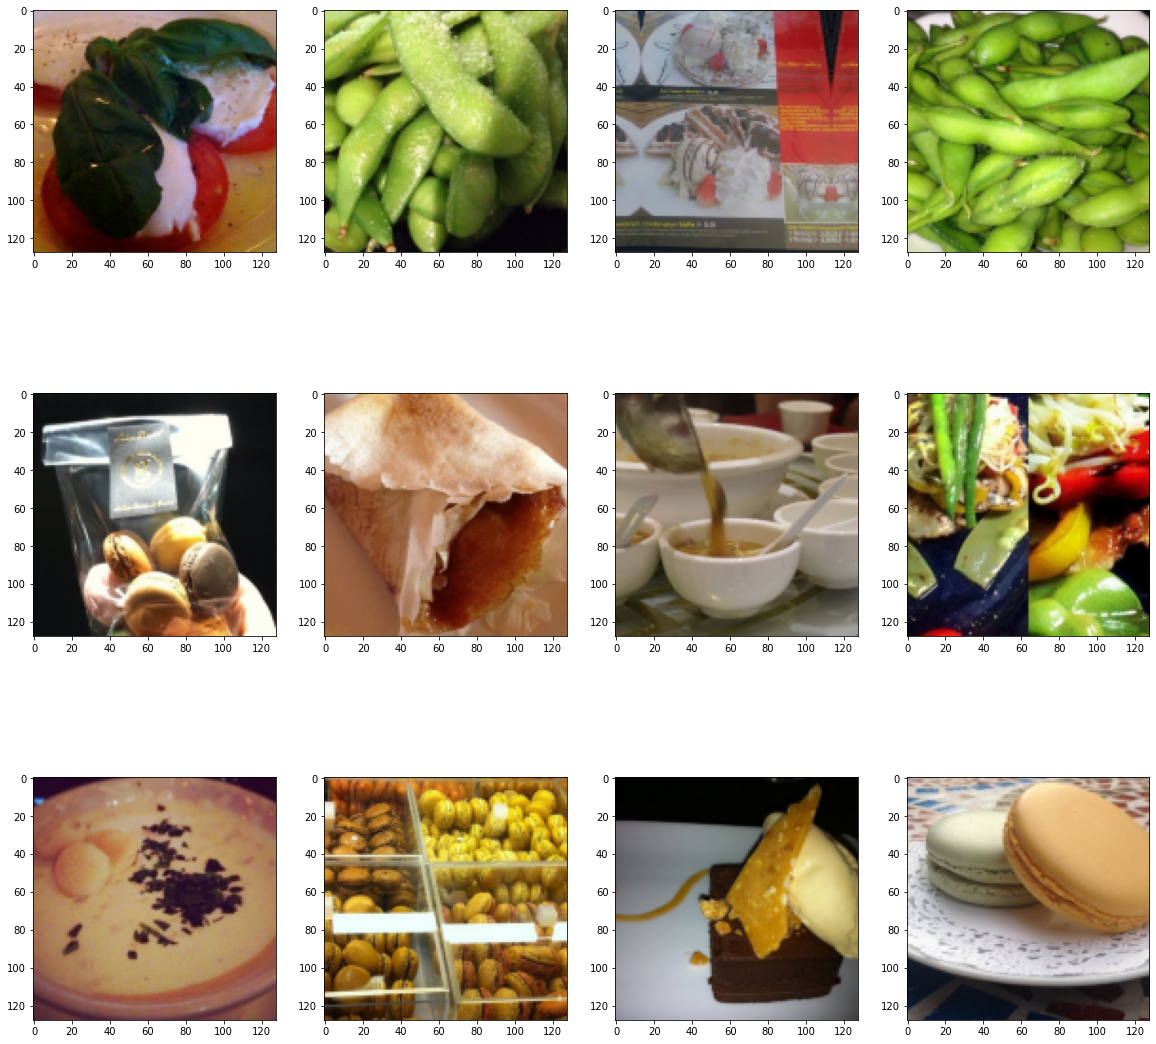

In [8]:
# checking to see the images rescaled successfully 
plt.subplots(3,4,figsize = (20,20))

for i in range(12):
    img_np = train_resized[i]
    plt.subplot(3,4,1+i)
    plt.imshow(img_np)
plt.show()

In [9]:
# creating validation split from training data 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_resized, train_category, test_size = 0.2, random_state = 42) 

In [10]:
#converting pixel values to float type, and then normalizing 
#since the training and test data does not follow a Gaussian distribution, we are normalizing instead of standardizing
# why normalize?  

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = test_images.astype('float32')

X_train = X_train/255
X_val = X_val/255
X_test = test_images/255

In [11]:
#changing name of test category (what we're looking to predict)
y_test = test_category

In [12]:
print('X_train shape:',X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)


X_train shape: (800, 128, 128, 3)
X_val shape: (200, 128, 128, 3)
X_test shape: (1000, 128, 128, 3)


In [13]:
print('y_train shape:',y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test:', y_test.shape)

y_train shape: (800, 101)
y_val shape: (200, 101)
y_test: (1000, 101)


In [14]:
y_train[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

## CNN model without transformations or transfer learning 

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [16]:
model1 = Sequential()
model1.add(Conv2D(32, kernel_size =(3,3), activation = 'relu', input_shape = (128, 128, 3), padding = 'same'))
model1.add(Conv2D(32, kernel_size= (3,3), activation = 'relu', padding = 'same'))#how do we determine filter numbers
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Flatten())
model1.add(Dense(512, activation = 'relu'))#should we do randomsearch or GridSearch for units/layer
model1.add(Dropout(0.5))
model1.add(Dense(101, activation = 'softmax'))
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               5

In [17]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 10, batch_size = 32)

Epoch 1/10
25/25 [==============================] - 30s 1s/step - loss: 4.6228 - accuracy: 0.0099 - val_loss: 4.6157 - val_accuracy: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 29s 1s/step - loss: 4.6122 - accuracy: 0.0223 - val_loss: 4.6162 - val_accuracy: 0.0000e+00
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 4.6093 - accuracy: 0.0203 - val_loss: 4.6168 - val_accuracy: 0.0000e+00
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 4.6070 - accuracy: 0.0155 - val_loss: 4.6170 - val_accuracy: 0.0000e+00
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 4.6050 - accuracy: 0.0137 - val_loss: 4.6179 - val_accuracy: 0.0000e+00
Epoch 6/10
25/25 [==============================] - 29s 1s/step - loss: 4.5992 - accuracy: 0.0193 - val_loss: 4.6201 - val_accuracy: 0.0000e+00
Epoch 7/10
25/25 [==============================] - 28s 1s/step - loss: 4.5939 - accuracy: 0.0168 - val_loss: 4.6240 - val_accuracy: 0.0

In [18]:
_,acc = model1.evaluate(X_val, y_val)
print(acc * 100)

7/7 [==============================] - 1s 206ms/step - loss: 4.6382 - accuracy: 0.0000e+00
0.0
